<h1>Segmenting and Clustering Neighborhoods in Toronto<h1>

Libraries to import

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans

Download and convert to DataFrame Postal Code Dataset

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data = pd.read_html(url)
toronto = html_data[0]

In [3]:
toronto.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Drop Not Assigned Neighborhoods

In [4]:
indexNA = toronto[toronto['Borough'] == 'Not assigned'].index

In [5]:
toronto.drop(indexNA , inplace=True, axis = 0)

In [6]:
toronto.reset_index(drop=True, inplace=True)

In [7]:
toronto.loc[toronto['Neighbourhood'] == 'Not assigned']

,Postal Code,Borough,Neighbourhood


Check for duplicate postal codes

In [8]:
codes = toronto['Postal Code'].value_counts()

In [9]:
check = False
for i in codes:
    if i > 1:
        print(i.index) 
        check = True

if check  :
    print("duplicate found")
else :
    print("no duplicate found")

no duplicate found


Getting Postal Codes location from CSV file

In [10]:
csv_url = "https://cocl.us/Geospatial_data"
geocode = pd.read_csv(csv_url)

In [11]:
geocode.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
toronto.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Dataframes Join in order to accoplish the final goal

In [13]:
toronto_geocode = pd.concat([toronto, geocode], axis=1, join="outer")

In [14]:
toronto_geocode = toronto_geocode.loc[:,~toronto_geocode.columns.duplicated()]

In [15]:
toronto_geocode.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.806686,-79.194353
1,M4A,North York,Victoria Village,43.784535,-79.160497
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.770992,-79.216917
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.773136,-79.239476


Getting Toronto location

In [16]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Plotting Toronto Map

In [17]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_geocode['Latitude'], toronto_geocode['Longitude'], toronto_geocode['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h2>Retrieving data from Foursquare</h2>

In [18]:
CLIENT_ID = '41LCZZETFO04UOMJIPHUR5YWEOWP211TVYDW2KDVOM3XCP1Y' # your Foursquare ID
CLIENT_SECRET = '2EQZG3HEM40DWHLELELL0G0YHC3C4FNRXE0IVAV3F0K2IK23' # your Foursquare Secret
VERSION = '20210303' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 41LCZZETFO04UOMJIPHUR5YWEOWP211TVYDW2KDVOM3XCP1Y
CLIENT_SECRET:2EQZG3HEM40DWHLELELL0G0YHC3C4FNRXE0IVAV3F0K2IK23


In [43]:
#Function to get nearby venues given a location
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
toronto_venues = getNearbyVenues(names=toronto_geocode['Postal Code'],
                                   latitudes=toronto_geocode['Latitude'],
                                   longitudes=toronto_geocode['Longitude']
                                  )

In [90]:
print(toronto_venues.shape)
toronto_venues.head()

(2120, 7)


,Postal Code,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,M4A,43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
2,M4A,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,M5A,43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,M5A,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [91]:
#toronto_venues.drop_duplicates(inplace=True)

In [92]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 270 uniques categories.


In [93]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Code,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [94]:
toronto_onehot.shape

(2120, 271)

In [95]:
#toronto_onehot.drop_duplicates(inplace=True)

In [96]:
toronto_onehot.shape

(2120, 271)

In [97]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped

,Postal Code,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000

In [100]:
num_top_venues = 5

for hood in toronto_grouped['Postal Code']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Postal Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                venue  freq
0          Hobby Shop  0.17
1         Coffee Shop  0.17
2   Convenience Store  0.17
3  Chinese Restaurant  0.17
4         Bus Station  0.17


----M1C----
                       venue  freq
0  Latin American Restaurant   0.2
1             Clothing Store   0.2
2             Breakfast Spot   0.2
3                     Lounge   0.2
4               Skating Rink   0.2


----M1E----
                  venue  freq
0        Clothing Store  0.14
1           Coffee Shop  0.08
2  Fast Food Restaurant  0.06
3            Restaurant  0.05
4            Shoe Store  0.05


----M1G----
              venue  freq
0  Ramen Restaurant  0.09
1       Pizza Place  0.06
2              Café  0.06
3  Sushi Restaurant  0.06
4    Sandwich Place  0.06


----M1H----
                  venue  freq
0  Caribbean Restaurant   0.2
1    Athletics & Sports   0.2
2                   Gym   0.2
3                  Café   0.2
4   Japanese Restaurant   0.2


----M1J----
               venue  fr

                venue  freq
0        Skating Rink   0.4
1         Curling Ice   0.2
2                Park   0.2
3          Beer Store   0.2
4  Miscellaneous Shop   0.0


----M5K----
                  venue  freq
0  Fast Food Restaurant  0.10
1        Sandwich Place  0.10
2    Italian Restaurant  0.05
3     Fish & Chips Shop  0.05
4               Brewery  0.05


----M5L----
               venue  freq
0               Park  0.33
1              Trail  0.33
2         Restaurant  0.33
3  Accessories Store  0.00
4  Mobile Phone Shop  0.00


----M5M----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2         Cocktail Bar  0.04
3            Gastropub  0.04
4  American Restaurant  0.04


----M5N----
                venue  freq
0         Coffee Shop  0.08
1      Sandwich Place  0.08
2  Italian Restaurant  0.08
3          Hobby Shop  0.04
4     Thai Restaurant  0.04


----M5P----
              venue  freq
0    Airport Lounge  0.13
1   Airport Service  0.13


In [101]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [192]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Convenience Store,Hobby Shop,Department Store,Chinese Restaurant,Bus Station,Coffee Shop,Yoga Studio,Drugstore,Dog Run,Doner Restaurant
1,M1C,Clothing Store,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Shoe Store,Food Court,Japanese Restaurant,Juice Bar,Bank,Boutique
3,M1G,Ramen Restaurant,Coffee Shop,Sushi Restaurant,Sandwich Place,Pizza Place,Café,Restaurant,Bubble Tea Shop,Ice Cream Shop,Steakhouse
4,M1H,Caribbean Restaurant,Japanese Restaurant,Gym,Café,Athletics & Sports,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


In [193]:
toronto_grouped_clustering.head()

,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,clusters
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.

<h2>Clustering</h2>

Using elbow method to retrieve optimal number of k to use

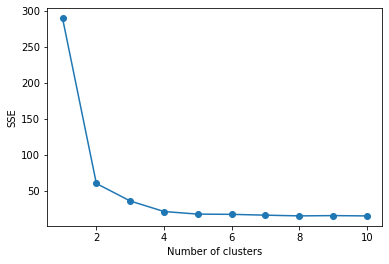

In [203]:
import matplotlib.pyplot as plt
sse = []
for k in range(1, 11):
    #the result is always the same regardless of parameters used
    kmeans = KMeans(n_clusters=k, init='random', n_init=100, max_iter=800, random_state=0).fit(toronto_grouped_clustering)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [179]:
# set number of clusters 
#2 is a good number (see above)
kclusters = 2

toronto_grouped_clustering = toronto_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, max_iter=300, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10].astype(int) 

In [180]:
toronto_grouped_clustering.head()

,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.

In [181]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))

toronto_merged = toronto_geocode

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.806686,-79.194353,0.0,Fast Food Restaurant,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
1,M4A,North York,Victoria Village,43.784535,-79.160497,0.0,Bar,Home Service,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711,0.0,Mexican Restaurant,Bank,Breakfast Spot,Medical Center,Electronics Store,Restaurant,Rental Car Location,Intersection,Doner Restaurant,Distribution Center
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.770992,-79.216917,0.0,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.773136,-79.239476,0.0,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Bakery,Thai Restaurant,Gas Station,Caribbean Restaurant,Lounge,Curling Ice


In [182]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,M1B,Convenience Store,Hobby Shop,Department Store,Chinese Restaurant,Bus Station,Coffee Shop,Yoga Studio,Drugstore,Dog Run,Doner Restaurant
1,0,M1C,Clothing Store,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,0,M1E,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Shoe Store,Food Court,Japanese Restaurant,Juice Bar,Bank,Boutique
3,0,M1G,Ramen Restaurant,Coffee Shop,Sushi Restaurant,Sandwich Place,Pizza Place,Café,Restaurant,Bubble Tea Shop,Ice Cream Shop,Steakhouse
4,0,M1H,Caribbean Restaurant,Japanese Restaurant,Gym,Café,Athletics & Sports,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


In [183]:
toronto_merged.dropna(inplace=True)
toronto_merged.shape

(99, 16)

Clusters Representation

In [184]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Postal Code'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [233]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0]
+ list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,0.0,Fast Food Restaurant,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
1,M4A,0.0,Bar,Home Service,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M5A,0.0,Mexican Restaurant,Bank,Breakfast Spot,Medical Center,Electronics Store,Restaurant,Rental Car Location,Intersection,Doner Restaurant,Distribution Center
3,M6A,0.0,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
4,M7A,0.0,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Bakery,Thai Restaurant,Gas Station,Caribbean Restaurant,Lounge,Curling Ice
5,M9A,0.0,Playground,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
6,M1B,0.0,Convenience Store,Hobby Shop,Department Store,Chinese Restaurant,Bus Station,Coffee Shop,Yoga Studio,Drugstore,Dog Run,Doner Restaurant
7,M3B,0.0,Bus Line,Bakery,Bus Station,Ice Cream Shop,Intersection,Soccer Field,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
8,M4B,0.0,Motel,American Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
9,M5B,0.0,College Stadium,Café,Skating Rink,General Entertainment,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


In [234]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0]
+ list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,M4C,1.0,Playground,Park,Intersection,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
23,M4G,1.0,Park,Convenience Store,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
25,M6G,1.0,Food & Drink Shop,Park,Construction & Landscaping,Hotel,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
30,M5H,1.0,Airport,Park,Business Service,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
40,M3K,1.0,Metro Station,Park,Convenience Store,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
44,M1L,1.0,Park,Swim School,Bus Line,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
48,M5L,1.0,Park,Restaurant,Trail,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
50,M9L,1.0,Park,Playground,Trail,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
74,M5R,1.0,Park,Women's Store,Pool,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
79,M4S,1.0,Park,Bakery,Construction & Landscaping,Trail,Basketball Court,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [235]:
toronto_merged.shape

(99, 16)

Here I create two dfs based on clusters

In [236]:
toronto_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

In [237]:
toronto_0.shape

(87, 16)

In [238]:
toronto_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

In [239]:
toronto_1.shape

(12, 16)

then I plot occurences of 1st 2nd and 3rd most common values in order to give an interpretation

<h3>Cluster 0</h3>

<AxesSubplot:ylabel='1st Most Common Venue'>

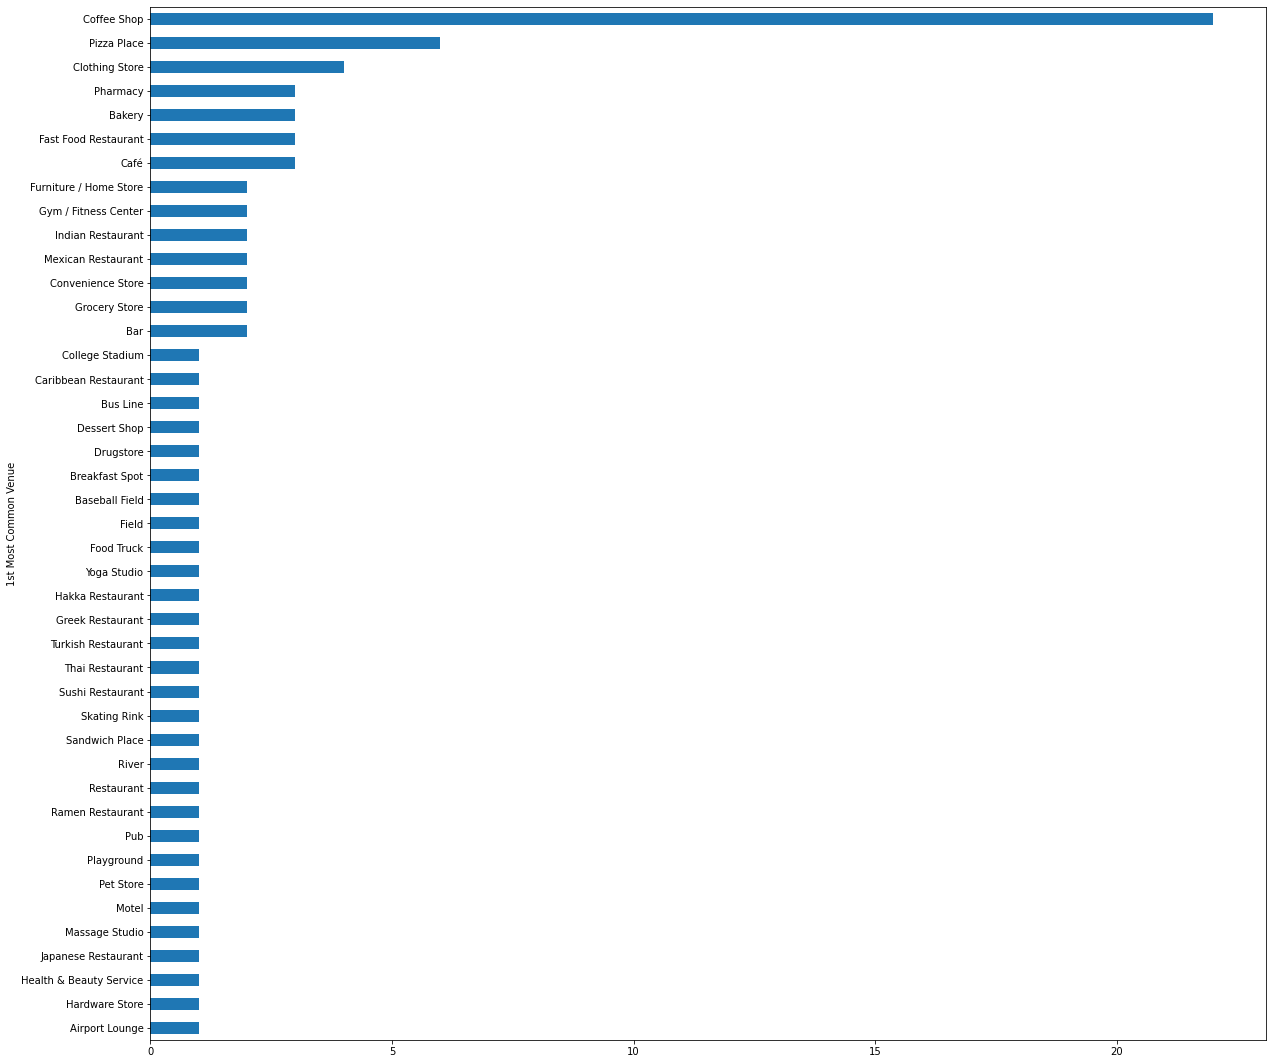

In [247]:
toronto_0.value_counts('1st Most Common Venue',ascending=True).plot(kind='barh',figsize=(20, 19))

<AxesSubplot:ylabel='2nd Most Common Venue'>

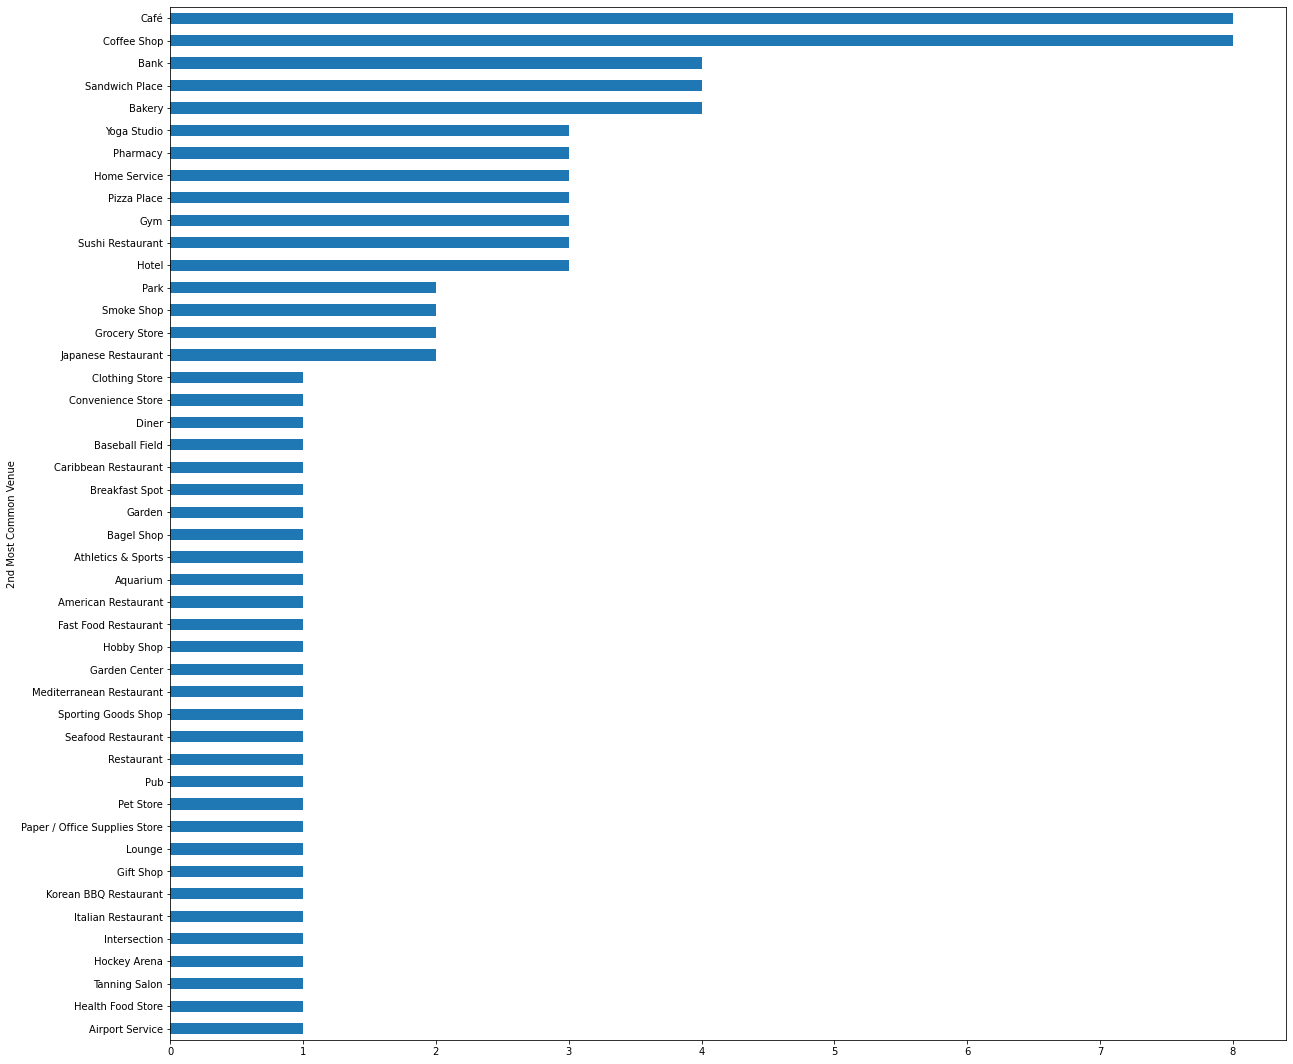

In [249]:
toronto_0.value_counts('2nd Most Common Venue',ascending=True).plot(kind='barh',figsize=(20, 19))

<AxesSubplot:ylabel='3rd Most Common Venue'>

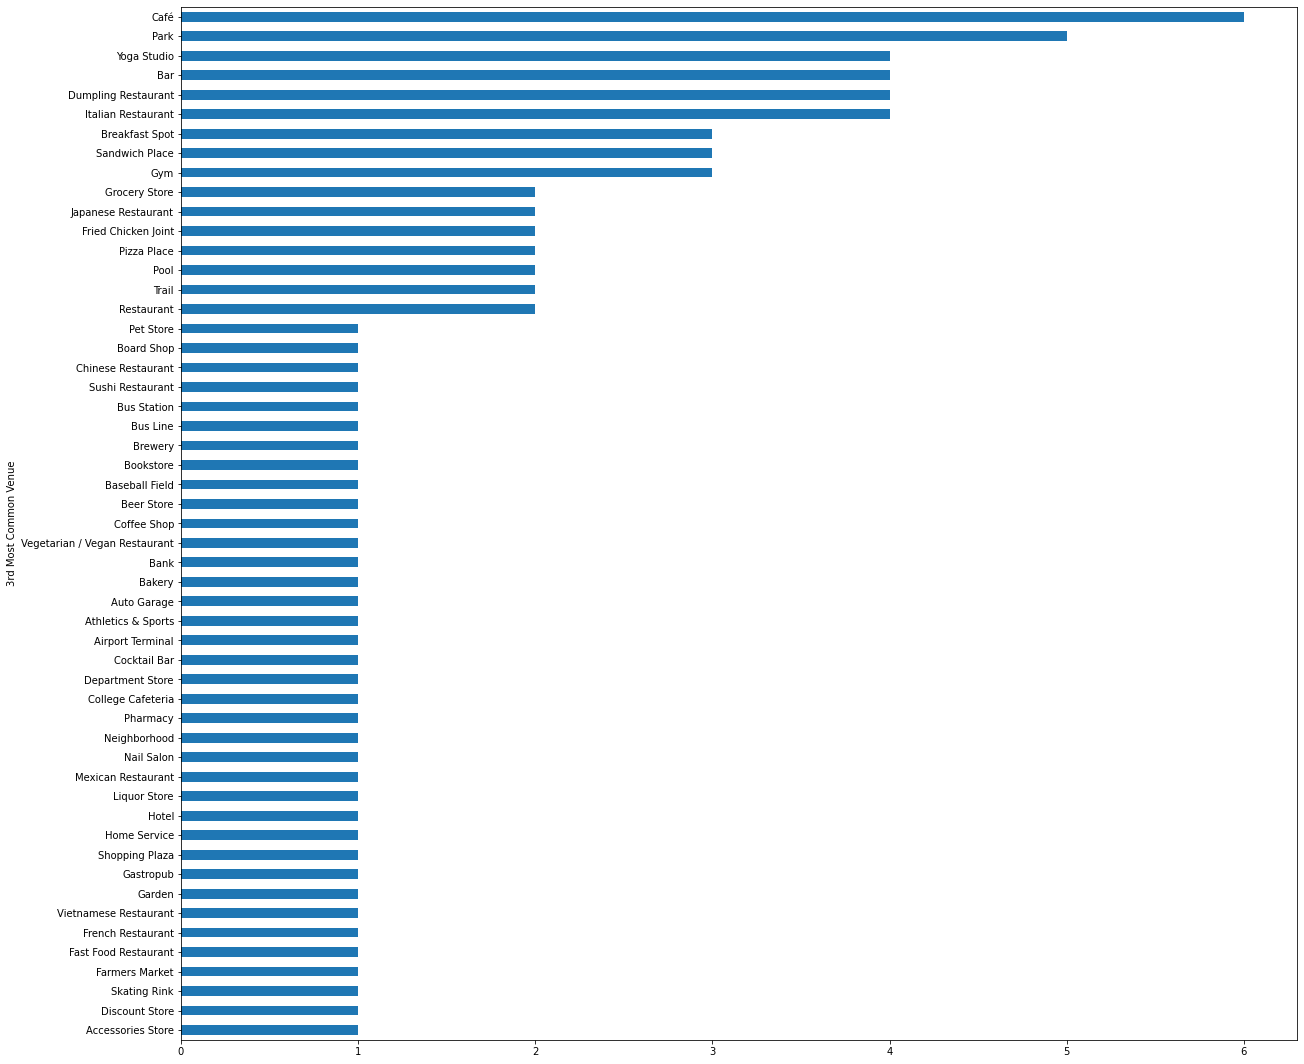

In [250]:
toronto_0.value_counts('3rd Most Common Venue',ascending=True).plot(kind='barh',figsize=(20, 19))

<h3>Cluster 1</h3>

<AxesSubplot:ylabel='1st Most Common Venue'>

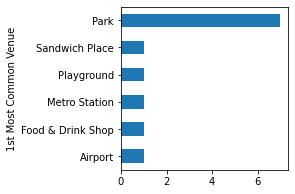

In [253]:
toronto_1.value_counts('1st Most Common Venue',ascending=True).plot(kind='barh',figsize=(3, 3))

<AxesSubplot:ylabel='2nd Most Common Venue'>

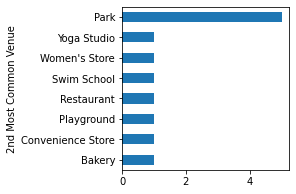

In [254]:
toronto_1.value_counts('2nd Most Common Venue',ascending=True).plot(kind='barh',figsize=(3, 3))

<AxesSubplot:ylabel='3rd Most Common Venue'>

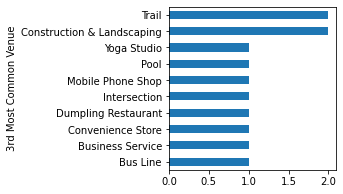

In [255]:
toronto_1.value_counts('3rd Most Common Venue',ascending=True).plot(kind='barh',figsize=(3, 3))

<h6>Final Remarks</h6>
Accoring to the cluster distribution we have two clusters, they are unbalanced because Cluster 0 contains more elements than Cluster 1. Cluster 0 is monopolized by Coffee Shops and Cafes while Cluster 1 we can see a predominance of Park elements. This partition could justify the disparity between clusters because in Toronto there are more Coffee Shops than Parks. If we analyze all the kind of venues in Cluster 0 are contained all of them related to food (es. Restaurant) while in Cluster 1 there are venues pertinent to other kind of services (Playground, Trail and so on).